<h1> HR Analytics: Job Change of Data Scientists

![gif](https://westwoodcardinalchronicle.com/wp-content/uploads/2015/05/should-i-stay.gif "should i stay or should i go")


**Task Details**

This dataset is designed to understand the factors that lead employee to leave current job by various ML models that use the current credentials/demographics/experience/work status to predict the probability of a employee to look for a new job or will work for the company.

**Notes**

The dataset is heavily imbalanced.

Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.

**Columns**

enrollee_id : Unique ID for candidate

city: City code

city_development_index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline: Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

**target: 0 – Not looking for job change, 1 – Looking for a job change**

<h1> Import data libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

<h1> Load data

In [2]:
train_data = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv') 

<h1> Exploratory Data Analysis

In [3]:
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
train_data.shape

(19158, 14)

It looks like some values in the dataset are NaN, we would like to further inspect to which extent it affects our data.

In [5]:
print("Missing values in the train dataset:\n\n",train_data.isna().sum())

Missing values in the train dataset:

 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


Let's plot all the column into barcharts to see the distribution of values. As we want our chart to be accesible, we will use colorblind palette. 👀

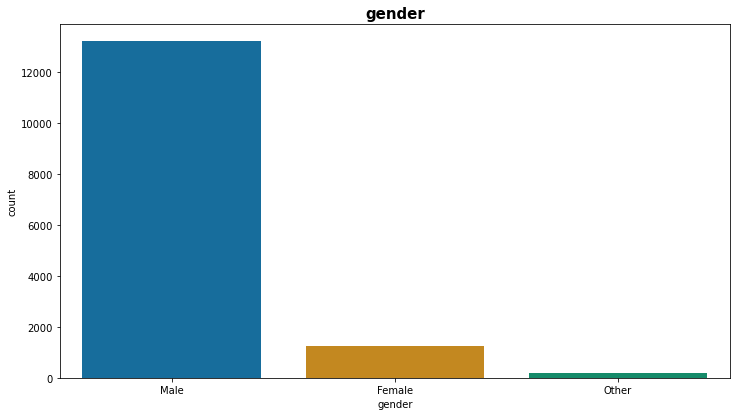

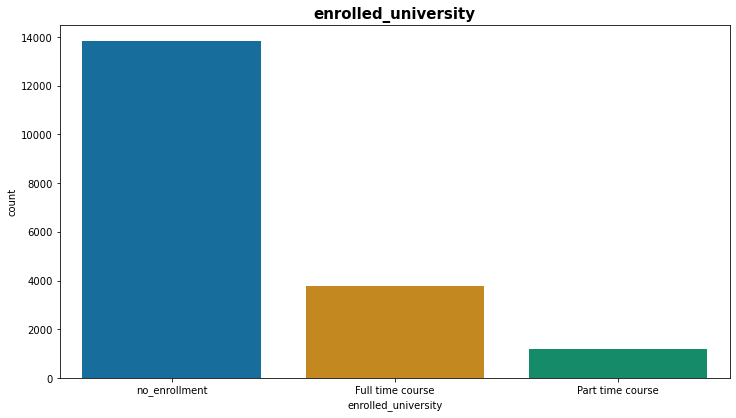

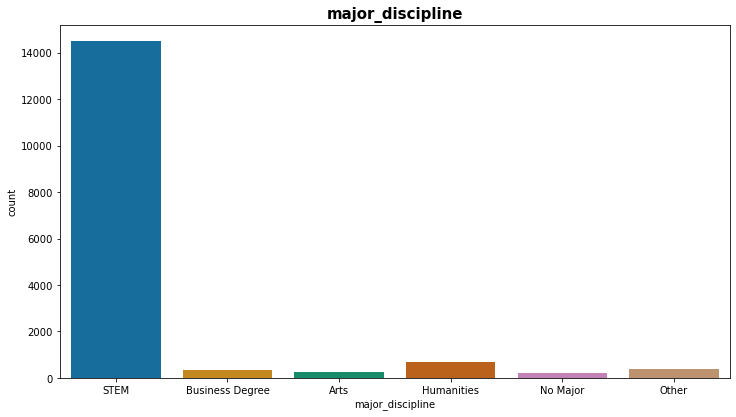

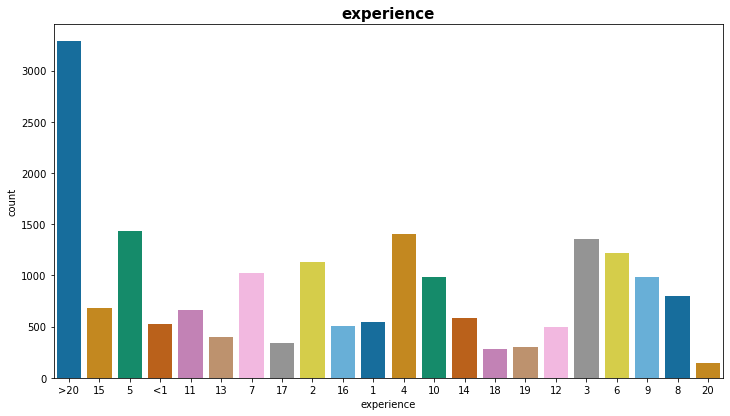

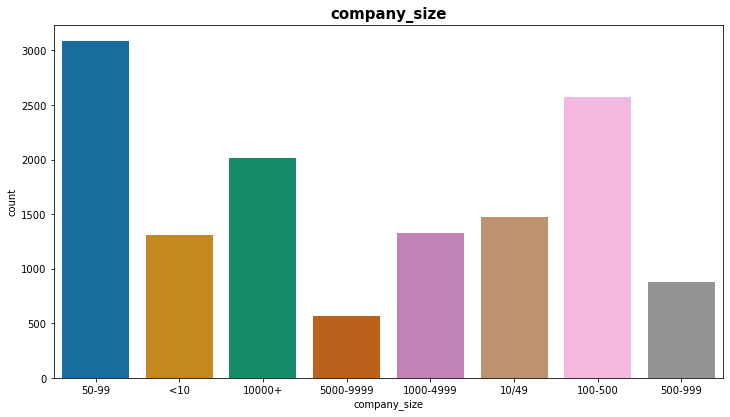

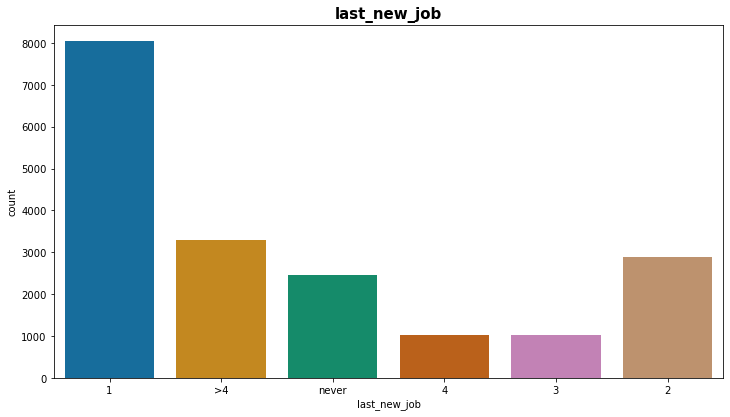

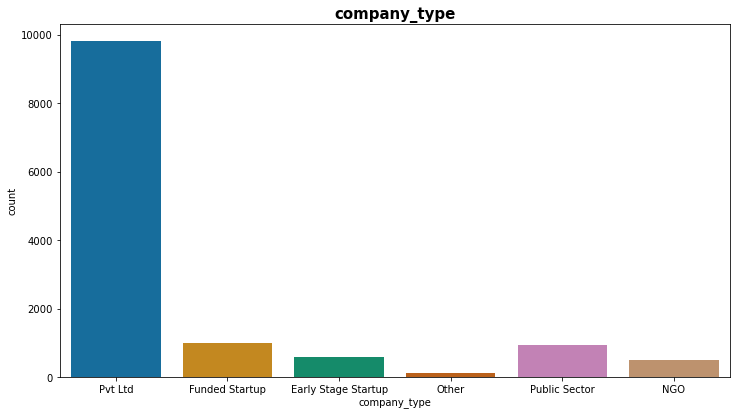

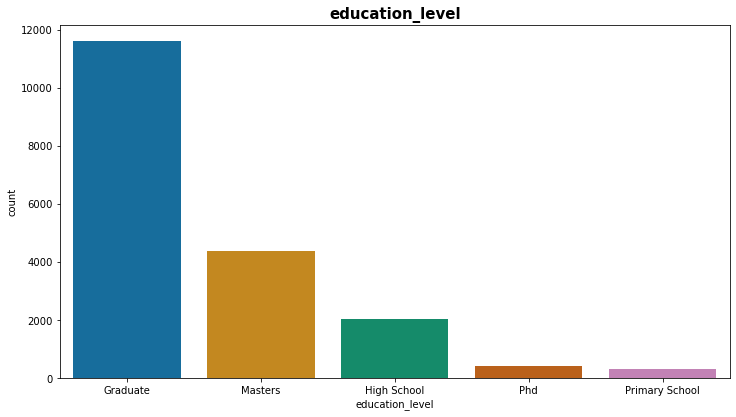

In [6]:
cols_with_nan_data = train_data[['gender', 'enrolled_university', 'major_discipline', 'experience', 'company_size', 'last_new_job', 'company_type', 'education_level']]   
colorblind_palette = sns.color_palette("colorblind")

for i in cols_with_nan_data:
    plt.figure(figsize=(12,6.5)) 
    plt.title(i, fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
    sns.countplot(data = train_data[i], x = cols_with_nan_data[i], palette=colorblind_palette)
    plt.show()

We are also interested in whether the target variable is balanced or not.

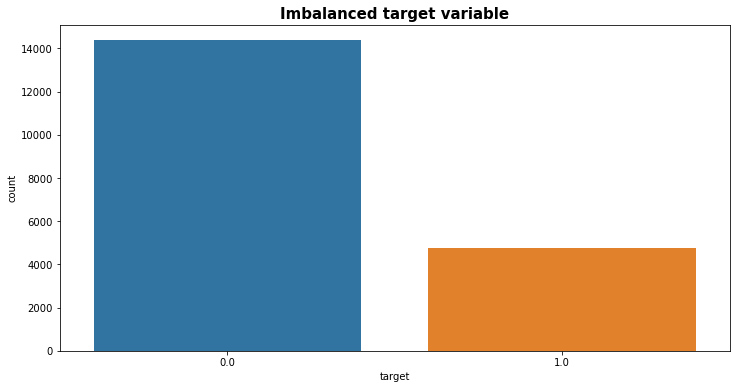

In [7]:
plt.figure(figsize=(12,6))
plt.title("Imbalanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x='target', data=train_data)

**From the information we've learned about our dataset, we have to deal with the following challenges:**
* There are NaN values in some attributes  that we need to replace properly (new category, replace with most frequent values, median, mean,...)
* The target variable "target" is highly unbalanced, it needs to be balanced in order to be able to implement ML with fair results

<h1> Data wrangling

<h2>Handling null values

In [8]:
data=train_data
data.shape

(19158, 14)

Now we will take care of all attributes with NaN values as shown in graphs above.

In [9]:
data['city'] = data['city'].str.split("_",expand=True)[1].astype('int64')
data['gender'] = data['gender'].replace(np.nan, 'Male')
data['enrolled_university'] = data['enrolled_university'].replace(np.nan, 'no_enrollment')
data['education_level'] = data['education_level'].replace(np.nan,'Graduate')
data['major_discipline'] = data['major_discipline'].replace(np.nan,'STEM')
data['experience'] = data['experience'].replace(np.nan,'>20')
data['company_size'] = data['company_size'].replace(np.nan,'50-99')
data['company_type'] = data['company_type'].replace(np.nan,'Pvt Ltd')
data['last_new_job'] = data['last_new_job'].replace(np.nan,'1')

Since value 'Other' has very low frequency in gender attribute, we will get rid of it.

In [10]:
data = data[data.gender != 'Other']

In [11]:
data.shape

(18967, 14)

We've successfully replaced all NaN values:

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18967 non-null  int64  
 1   city                    18967 non-null  int64  
 2   city_development_index  18967 non-null  float64
 3   gender                  18967 non-null  object 
 4   relevent_experience     18967 non-null  object 
 5   enrolled_university     18967 non-null  object 
 6   education_level         18967 non-null  object 
 7   major_discipline        18967 non-null  object 
 8   experience              18967 non-null  object 
 9   company_size            18967 non-null  object 
 10  company_type            18967 non-null  object 
 11  last_new_job            18967 non-null  object 
 12  training_hours          18967 non-null  int64  
 13  target                  18967 non-null  float64
dtypes: float64(2), int64(3), object(9)
mem

<h2> Conversion of categorical variables into numeric variables

In [13]:
pd.options.mode.chained_assignment = None
ordinal_atributes = ['education_level', 'experience', 'company_size', 'last_new_job']

cardinal_atributes = ['gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']

ordinal_pipeline = Pipeline([
    ('OrdinalEncoder',OrdinalEncoder(categories=[
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','<10', '10/49', '50-99', '100-500', '500-999' ,'1000-4999', '5000-9999', '10000+'],
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))
])

ordinal_pipeline.fit(data[ordinal_atributes])
data[ordinal_atributes] = ordinal_pipeline.transform(data[ordinal_atributes])
data = pd.get_dummies(data, columns=cardinal_atributes)
data.head()

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,8949,103,0.920,3.0,22.0,3.0,1.0,36,1.0,0,...,0,0,0,1,0,0,0,0,0,1
1,29725,40,0.776,3.0,16.0,3.0,5.0,47,0.0,0,...,0,0,0,1,0,0,0,0,0,1
2,11561,21,0.624,3.0,6.0,3.0,6.0,83,0.0,0,...,0,0,0,1,0,0,0,0,0,1
3,33241,115,0.789,3.0,1.0,3.0,6.0,52,1.0,0,...,0,0,0,0,0,0,0,0,0,1
4,666,162,0.767,4.0,22.0,3.0,4.0,8,0.0,0,...,0,0,0,1,0,1,0,0,0,0


Let's check how many columns do we have at this moment.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   enrollee_id                                  18967 non-null  int64  
 1   city                                         18967 non-null  int64  
 2   city_development_index                       18967 non-null  float64
 3   education_level                              18967 non-null  float64
 4   experience                                   18967 non-null  float64
 5   company_size                                 18967 non-null  float64
 6   last_new_job                                 18967 non-null  float64
 7   training_hours                               18967 non-null  int64  
 8   target                                       18967 non-null  float64
 9   gender_Female                                18967 non-null  uint8  
 10

<h2> Balancing target variable

To balance our target variable, we will use RandomOverSampler from imblearn library.

In [15]:
columns = data.columns.tolist()
columns = [c for c in columns if c not in ['target']]
y = data['target']
X = data[columns]

ros = RandomOverSampler(sampling_strategy='minority')
X_ros, y_ros = ros.fit_resample(X, y)
print(f"Imbalanced target class: {Counter(y)}\n\nBalanced target class: {Counter(y_ros)}\n")
print(X_ros.shape[0] - data.shape[0], 'new random picked points')

Imbalanced target class: Counter({0.0: 14240, 1.0: 4727})

Balanced target class: Counter({1.0: 14240, 0.0: 14240})

9513 new random picked points


We can see our result in barchart below 📊 ->

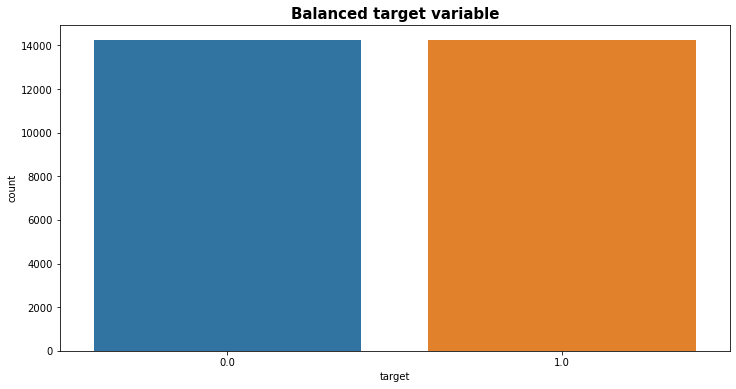

In [16]:
plt.figure(figsize=(12,6))
plt.title("Balanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x=y_ros, data=data)

Perfect! Our dataset is now balanced. 😎

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   enrollee_id                                  18967 non-null  int64  
 1   city                                         18967 non-null  int64  
 2   city_development_index                       18967 non-null  float64
 3   education_level                              18967 non-null  float64
 4   experience                                   18967 non-null  float64
 5   company_size                                 18967 non-null  float64
 6   last_new_job                                 18967 non-null  float64
 7   training_hours                               18967 non-null  int64  
 8   target                                       18967 non-null  float64
 9   gender_Female                                18967 non-null  uint8  
 10

In [18]:
data.shape

(18967, 28)

Our dataset is all set and ready to be used in various ML models! 🔎

<h1> Models

In [19]:
X_ros,X_test,y_ros,y_test = train_test_split(X, y,test_size=0.3,stratify=y,random_state=42)
X_ros.shape,X_test.shape,y_ros.shape,y_test.shape

((13276, 27), (5691, 27), (13276,), (5691,))

**KNN**

In [20]:
knnc = KNeighborsClassifier(n_neighbors=4)
knnc.fit(X_ros, y_ros)
y_pred_knnc = knnc.predict(X_test)

print(classification_report(y_test, y_pred_knnc))
print('The accuracy score with using the KNN is :',accuracy_score(y_test,y_pred_knnc))

NameError: name 'KNeighborsClassifier' is not defined

In [21]:
params = {'n_neighbors': np.arange(1, 31, 2), "metric": ["euclidean"]}
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)
# returns the best model
grid_search_cv.best_estimator_
# the best parameters
grid_search_cv.best_params_
# results obtained by the best model
knn_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned KNN is: ', knn_accuracy)

NameError: name 'KNeighborsClassifier' is not defined

In [22]:
plot_roc_curve(grid_search_cv, X_test, y_test)

NameError: name 'grid_search_cv' is not defined

**DECISION TREE**

In [23]:
dtc = DecisionTreeClassifier(max_depth = 3, random_state=0)

dtc.fit(X_ros, y_ros)
y_pred_dtc = dtc.predict(X_test)
#metrics.accuracy_score(y_test, y_pred_dtc)

print(classification_report(y_test, y_pred_dtc))
print('The accuracy score with using the decision tree classifier is :',accuracy_score(y_test,y_pred_dtc))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      4273
         1.0       0.59      0.44      0.50      1418

    accuracy                           0.78      5691
   macro avg       0.71      0.67      0.68      5691
weighted avg       0.77      0.78      0.77      5691

The accuracy score with using the decision tree classifier is : 0.7829906870497276


**Hyperparameter tuning**

In [24]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)
# returns the best model
grid_search_cv.best_estimator_
# the best parameters
grid_search_cv.best_params_
# results obtained by the best model
dt_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned decision tree classifier is: ', dt_accuracy)

Fitting 3 folds for each of 294 candidates, totalling 882 fits
The accuracy score with using the tuned decision tree classifier is:  0.7823893054481181


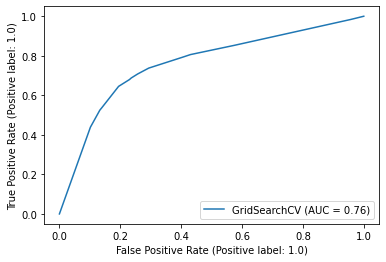

In [25]:
plot_roc_curve(grid_search_cv, X_test, y_test)

**RANDOM FOREST**

In [26]:
rfc = RandomForestClassifier(n_estimators = 50, class_weight = {0:1, 1:4})
rfc.fit(X_ros, y_ros)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
print('The accuracy score with using the Random Forest is :',accuracy_score(y_test,y_pred_rfc))

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86      4273
         1.0       0.56      0.35      0.43      1418

    accuracy                           0.77      5691
   macro avg       0.68      0.63      0.64      5691
weighted avg       0.75      0.77      0.75      5691

The accuracy score with using the Random Forest is : 0.7698119838341241


In [27]:
params = {'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)

grid_search_cv.best_estimator_
grid_search_cv.best_params_
rf_accuracy = grid_search_cv.best_score_ 
print('The accuracy score with using the tuned Random Forest is :',rf_accuracy)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
The accuracy score with using the tuned Random Forest is : 0.7695089366634243


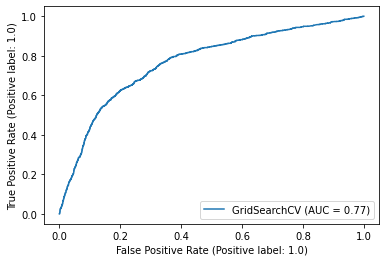

In [28]:
plot_roc_curve(grid_search_cv, X_test, y_test)

**XGB classifier**

In [29]:
xgbc = XGBClassifier(use_label_encoder=False)
xgbc.fit(X_ros,y_ros)
xgb_accuracy = accuracy_score(y_test,xgbc.predict(X_test))
print('The accuracy using the XGBclassifier is :', xgb_accuracy)

[12:56:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy using the XGBclassifier is : 0.7706905640484977


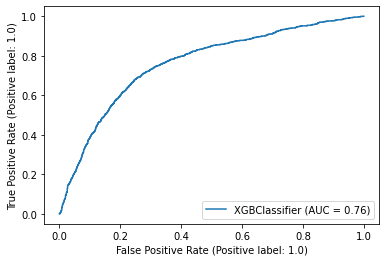

In [30]:
plot_roc_curve(xgbc, X_test, y_test)

# Comparison of Models

Let's check out which one out of our models has the best accuracy score.

In [31]:
accuracies = {"KNN Accuracy":knn_accuracy, "Decision Tree Accuracy":dt_accuracy, "Random Forest Accuracy":rf_accuracy, "XGB Accuracy":xgb_accuracy}
print("The best score has the model: ", max(accuracies, key=accuracies.get))

NameError: name 'knn_accuracy' is not defined

The decission tree model has the highest accuracy. Let's now chek how good were another ones!

In [32]:
plt.figure(figsize=(20,10))
plt.bar(*zip(*accuracies.items()), color=colorblind_palette, width = 0.8)
plt.title("Comparison of different models accuracies")
plt.show()

NameError: name 'accuracies' is not defined

<Figure size 1440x720 with 0 Axes>